In [39]:
# local python tests
from pprint import pprint
from igraph import *
import igraph.test
import pickle
import os
import numpy as np
from scipy.sparse import csr_matrix
import collections
import copy
from random import randint





"""

    %%%%%%%%%%%%%%%%%%%%%%%%%%% gcn tests %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    x  feature vectors
    tx feature vectors for test (unlabeled)
    allx feature vectors for all

    y  label vectors       numpy.ndarray
    ty test label vectors  numpy.ndarray
    ally  test label of all

    graph : adjacency matrix (dict of lists)
    test.index: node id list for tests?


    steps
    1) inspect ind.citeseer.x/tx/y/ty/allx/ally/test.index

    2) build those files from code

    3) call learning algorithm
        cd src/notebooks
        python gcn_tests_input.py&&  cp ind.* ../gcn/gcn/gcn/data
        cd src/gcn/gcn/gcn
        python train.py --dataset t1


    4) look at embedding result

"""


def pickleToDisk(myobj, filepath):
    pickle.dump(myobj, open(filepath, "wb"))


def printGraphObject(filepath):


    myobject = os.path.basename(filepath)
    print("\n\n*************** "+myobject+" ********************")
    y = pickle.load(open(filepath,'rb'))
    print(type(y))
    if type(y) ==  type([]) or type(y) == type(np.ndarray([])):
        
        print(len(y))
        pprint(y[:min(3,len(y)-1)])
    elif type(y) == type({}) or type(y)==type(collections.defaultdict()):
        pprint(y.keys()[:min(3,len(y)-1)])
        pprint(y[y.keys()[0]])
        pprint(y[y.keys()[1]])
        pprint(y[y.keys()[20]])
        pprint(y[y.keys()[3000]])

    else:
        
        pprint(y.shape)
        pprint(y[0,:min(3,y.shape[1]-1)].toarray())
        pprint(y[0,0].shape)
        pprint(type(y[0,0]))
        pprint(y[0,0])

def readListFile(filepath):
    myobject = os.path.basename(filepath)
    print("\n\n*************** "+myobject+" ********************")
    

    testInstances =[]
    with open(filepath, 'rb') as f:
        for line in f.readlines():
            testInstances.append(int(line))

    pprint(testInstances[:min(3,len(testInstances)-1)])


def inspectData():

    printGraphObject('../gcn/gcn/gcn/data/ind.citeseer.y')
    printGraphObject('../gcn/gcn/gcn/data/ind.citeseer.ty')
    printGraphObject('../gcn/gcn/gcn/data/ind.citeseer.x')
    printGraphObject('../gcn/gcn/gcn/data/ind.citeseer.tx')
    printGraphObject('../gcn/gcn/gcn/data/ind.citeseer.graph')
    readListFile('../gcn/gcn/gcn/data/ind.citeseer.test.index')
    printGraphObject('../gcn/gcn/gcn/data/ind.citeseer.allx')
    printGraphObject('../gcn/gcn/gcn/data/ind.citeseer.ally')


def discretize(elements):
    """ create a binary array for each of the 10 ranges of values between 0 and 1"""
    orig = np.array(elements)
    results = []
    for i in range(10):
        print(i) 
        if i<9:
            range1 = np.bitwise_and(orig >= 0.1*i ,orig <= 0.1*(i+1))
        else:
            range1 = orig >= 0.1*i
        print(range1)
        results.append(range1) 
        
    result = np.transpose(np.asarray(results))
    print(result.shape)
    return result


def generateData(suffix, n_node=1000, n_test=200, n_train=300 ):
    
    

    #igraph.test.run_tests()

    # generation
    #g = Graph.Tree(127, 2)
    #g = Graph.GRG(100, 0.2)
    #g = Graph.Erdos_Renyi(100, 0.2)
    #g = Graph.Watts_Strogatz(1, 100, 4, 0.5 )
    g = Graph.Barabasi(n_node)
    summary(g)

    # graph metrics
    # pprint(g.degree([2,3,6,99]))
    # pprint(g.edge_betweenness())
    # pprint(g.pagerank())
    #pprint(g.get_adjacency())
    #pprint(dir(g))
    


    # test.index
    testList = [] 
    with open(suffix+'.test.index','wb') as f:
        while len(testList) < n_test:
            j = randint(0, n_node-1)
            #verify it is not alerady there
            try:
                pos = testList.index(j)
            except:
                testList.append(j)
            f.write(str.encode(str(j)+"\n"))


    # adjacency dict (graph)
    i = 0
    A = g.get_adjlist()
    graphAdj = {}
    for node in A:
        graphAdj[i] = node
        i+=1
    pickleToDisk(graphAdj, suffix+".graph")

    
    xFeatures = np.ones(n_node)
    # allx is for labeled and unlabeled training samples
    allx  = copy.deepcopy([xFeatures[i] for i in range(n_node) if i not in testList])
    # x is for labeled training samples only
    x = copy.deepcopy(allx[:-500])
    #tx = copy.deepcopy(xFeatures[range(n_node-n_test, n_node)])
    tx = [xFeatures[i] for i in testList]
    

    
    allx = csr_matrix(allx)
    allx = np.transpose(allx)
    pickleToDisk(allx, suffix+".allx")
    x = csr_matrix(x)
    x = np.transpose(x)
    pickleToDisk(x, suffix+".x")
    tx = csr_matrix(tx)
    tx = np.transpose(tx)
    pickleToDisk(tx, suffix+".tx")

    print(x.shape)
    print(tx.shape)
    print(allx.shape)
    


    # labels (ally,y , ty)
    prs = discretize(g.pagerank())

    

    # labels of x, and empty labels of unlabeled training samples
    prs_all = copy.deepcopy([prs[i] for i in range(n_node) if i not in testList])
    # labels of the labeled training samples
    prs_train = copy.deepcopy(prs_all[:-500])
    prs_test = copy.deepcopy([prs[i] for i in testList])
    #testList.extend(validationList)
    #finalList = testList
    #prs_train = [ prs[i] for i in range(prs.shape[0]) if i not in finalList ]

    ally = np.array(prs_all)
    y = np.array(prs_train)  
    ty = np.array(prs_test)


    pickleToDisk(ally, suffix+".ally")
    pickleToDisk(y, suffix+".y")
    pickleToDisk(ty, suffix+".ty")
    
    print(y.shape)
    print(ty.shape)
    print(ally.shape)
    
    

    # run training on those files

In [40]:
generateData(suffix="ind.t3",n_node=4000, n_train=700, n_test=300)
!mv ind.* ./data/

IGRAPH U--- 4000 3999 -- 
(3200, 1)
(300, 1)
(3700, 1)
0
[ True  True  True ...  True  True  True]
1
[False False False ... False False False]
2
[False False False ... False False False]
3
[False False False ... False False False]
4
[False False False ... False False False]
5
[False False False ... False False False]
6
[False False False ... False False False]
7
[False False False ... False False False]
8
[False False False ... False False False]
9
[False False False ... False False False]
(4000, 10)
(3200, 10)
(300, 10)
(3700, 10)


In [57]:
!~/.pyenv/shims/python  train.py --dataset t3


len(y): 3200
labels shape:
(4000, 10)
len(idx_train) 3200
len(idx_val) 500
len(idx_test) 310
features after row normalize and tuple
(array([[   0,    0],
       [   1,    0],
       [   2,    0],
       ...,
       [3997,    0],
       [3998,    0],
       [3999,    0]], dtype=int32),
 array([1., 1., 1., ..., 1., 1., 1.]),
 (4000, 1))
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

2019-01-22 09:52:38.005298: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
Epoch: 0001 train_loss= 2.40027 train_acc= 0.03344 val_loss= 2.33939 val_acc= 0.00000 time= 0.03728
Epoch: 0002 train_loss= 2.36241 train_acc= 0.04688 val_loss= 2.31095 val_acc= 0.00000 time= 0.01114
Epoch: 0003 train_loss= 2.32397 train_acc= 0.03469 val_loss= 2.28803 val_acc= 0.00000 time= 0.010

In [61]:
!~/.pyenv/shims/python  train.py --dataset cora


len(y): 140
labels shape:
(2708, 7)
len(idx_train) 140
len(idx_val) 500
len(idx_test) 1000
features after row normalize and tuple
(array([[   0, 1274],
       [   0, 1247],
       [   0, 1194],
       ...,
       [2707,  329],
       [2707,  186],
       [2707,   19]], dtype=int32),
 array([0.11111111, 0.11111111, 0.11111111, ..., 0.07692308, 0.07692308,
       0.07692308], dtype=float32),
 (2708, 1433))
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

2019-01-22 09:53:09.751662: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
Epoch: 0001 train_loss= 1.95369 train_acc= 0.17857 val_loss= 1.94959 val_acc= 0.19600 time= 0.04716
Epoch: 0002 train_loss= 1.94921 train_acc= 0.22857 val_loss= 1.94556 val_acc= 0.25000 time= 0.01971
Epoch: 0003 train_loss= 1.

Epoch: 0074 train_loss= 1.01581 train_acc= 0.62857 val_loss= 1.14444 val_acc= 0.65800 time= 0.01846
Epoch: 0075 train_loss= 0.99083 train_acc= 0.62143 val_loss= 1.14228 val_acc= 0.66200 time= 0.01877
Epoch: 0076 train_loss= 1.05695 train_acc= 0.60000 val_loss= 1.14428 val_acc= 0.66000 time= 0.01813
Epoch: 0077 train_loss= 1.06611 train_acc= 0.62857 val_loss= 1.14551 val_acc= 0.65200 time= 0.02010
Epoch: 0078 train_loss= 1.04987 train_acc= 0.62143 val_loss= 1.14293 val_acc= 0.65200 time= 0.01935
Epoch: 0079 train_loss= 0.93315 train_acc= 0.70000 val_loss= 1.13907 val_acc= 0.65200 time= 0.02009
Epoch: 0080 train_loss= 0.92226 train_acc= 0.75000 val_loss= 1.13974 val_acc= 0.64400 time= 0.01857
Epoch: 0081 train_loss= 1.02945 train_acc= 0.61429 val_loss= 1.14003 val_acc= 0.64400 time= 0.02017
Epoch: 0082 train_loss= 0.93219 train_acc= 0.70000 val_loss= 1.14038 val_acc= 0.64400 time= 0.02021
Epoch: 0083 train_loss= 0.89969 train_acc= 0.72143 val_loss= 1.13858 val_acc= 0.63800 time= 0.01821


(2708, 2)
[-5.018782  -1.1500423 -3.1022313 ... -3.214873  -7.0004706 -6.470511 ]
[-1.0852845  1.9082782  1.3378185 ... -2.1315284 -2.673078  -2.3801403]


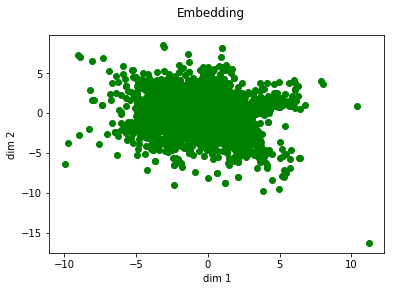

In [81]:

def plot2DEmbedding(filepath):
    import matplotlib.pyplot as plt
    %matplotlib inline

    # read embedding file
    embedding = np.zeros((1,1))
    with open(filepath,"r") as f:
        size = len(f.readlines())
        embedding = np.zeros((size,2))


    with open(filepath,"r") as f:
        i = 0
        for line in f.readlines():
            #print(line)
            d1,d2 = line.split()
            embedding[i,0] = float(d1)
            embedding[i,1] = float(d2)
            i=i+1

        #print(embedding.shape)
        #print(embedding[:,0])
        #print(embedding[:,1])
        
        plt.plot(embedding[:,0], embedding[:,1], c=, 'go')
        plt.suptitle('Embedding')
        plt.xlabel('dim 1')
        plt.ylabel('dim 2')
        plt.show()
    
plot2DEmbedding("embedding")

-5.018782 -1.0852845 
-1.1500423 1.9082782 
-3.1022313 1.3378185 
1.0100427 8.058594 
-2.4707184 -3.305365 
2.2860649 -2.8345156 
-0.57637 3.1717932 
-3.027207 1.1086533 
-4.121896 -1.5408868 
3.6268466 -3.9526148 
-0.8103602 1.8152269 
-0.4317279 2.1792014 
-9.084731 7.241668 
-1.9592661 -0.6718478 
-3.9268777 -0.53947645 
-2.7049806 0.0021212995 
3.4510896 -5.378254 
-8.257423 -2.033874 
-0.37208974 -4.306612 
-4.1796856 -0.35151595 
4.0278726 1.3819865 
-0.14575833 0.24927706 
-2.5188985 2.0602918 
-2.0535142 -1.9533261 
-4.498959 -0.56857413 
-1.8055038 1.1479144 
-4.308652 -4.1479044 
-3.136955 -0.21383654 
3.704382 -3.601269 
-0.51313186 1.4663498 
-1.6008475 -0.49028158 
-3.6718774 -0.626927 
-0.85903007 2.2646255 
-3.8737817 3.378274 
1.5623953 -1.94519 
-0.09066274 2.4419062 
0.3431517 -5.7255716 
2.3801236 2.5071707 
-3.390996 3.723943 
-3.3472974 3.7149415 
-1.4551129 0.4218372 
-1.050346 -1.1861933 
-3.5537858 -2.9203916 
-3.3936813 1.4407076 
-5.601039 -3.222194 
-5.012020